In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# from train_test_split import train_test_split_hoc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

#Language Models Exploration 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.models import Sequential
from keras.layers import Dense, InputLayer
import tensorflow as tf

In [303]:
# if not os.path.isfile("ssh_attacks_decoded_splitted.parquet"):
#     raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks.parquet")

In [304]:
%run "train_test_split_sampled.ipynb"
df_sampled = sampling(df)

<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>
<div style="text-align: justify">Experiment language models for solving the same supervised task as in Section 2. In this task, the objective is to harness the capabilities of language models like Bert or Word2Vec, for supervised learning (assign intents to sessions). 
<br><br> Two interesting concepts play a role when we use neural networks:
<div style="text-align: justify"><br><b>1)</b> It is possible to do transfer learning, i.e., to take a model that have been trained with other enormous datasets by Big Tech companies, and we can do fine-tuning i.e., to train this model starting from its pre-trained version.
<br><b>2)</b> In NLP tasks, words/documents are transformed into vectors (encoding) and this task is Unsupervised, so we can use a much larger amount of data.
</div><br>
<div style="text-align: justify"><b>4.1. If you choose Doc2Vec: pretrain Doc2Vec on body column of the session text. If you chose Bert: take the pretrained Bert model like in this example. (NB: In this tutorial they used BertForSequenceClassification, but if you want to continue with step 2, you must take an other Bert implementation from HuggingFace)</div><b>
<br><left><b><font size=3> Data Preparation and Cleaning </div></b>
<br><left><b><font size=2> Step 1 </div></b>
The initial phase involved loading the dataset from the 'ssh_attacks.parquet' file. To ensure data quality, a cleaning process was implemented on the 'full_session' column. Non-alphabetic characters were filtered out, and the text was converted to lowercase. This cleaning process was crucial for creating a meaningful representation of the session data.

In this endeavor, we embark on a journey to construct a robust Session Intent Classification model with the overarching goal of assigning intents to sessions using state-of-the-art techniques, specifically leveraging the Doc2Vec model and TensorFlow.

Our odyssey begins with the exploration of a dataset encapsulating session data, with the central task being the classification of intents. We harness the power of the Pandas library to load our dataset from a parquet file, granting us a glimpse into the raw data's structure.


A critical facet of our journey involves preparing the textual data for model ingestion. Employing a function to clean the text, we filter out non-alphabetic characters and convert the text to lowercase, ensuring uniformity and aiding in subsequent analysis.

Subsequently, we embark on the tokenization journey, a crucial step where we convert the cleaned sessions into tagged documents. This allows us to represent our textual data in a format suitable for training the Doc2Vec model.

In [305]:
tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]

##### Building and Training Doc2Vec Model

<div style="text-align: justify">{Cleaning the text data by removing non-alphabetic characters and converting text to lowercase. The Gensim library was used to train a Doc2Vec model on the cleaned text data. A vocabulary was buildt and the Doc2Vec model was trained to generate the vector of embeddings for each session text.}</div>

Our expedition proceeds with the training of the Doc2Vec model, an unsupervised learning algorithm designed to transform words or documents into numerical vectors. Configuring the model with specific parameters, such as vector size, window size, and epochs, we meticulously craft a representation of the textual data.

In [306]:
if not os.path.isfile("trained_doc2vec_model.model"):
    doc2vec_model = Doc2Vec(tagged_data)
    #doc2vec_model.build_vocab(tagged_data)
    #doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    doc2vec_model.save("trained_doc2vec_model.model")
else:
    doc2vec_model = Doc2Vec.load("trained_doc2vec_model.model")

##### Saving the Trained Model

Our grand architecture unfolds as we transition into building and training the classification model, integrating the pre-trained Doc2Vec embeddings.

We fashion a Sequential model in TensorFlow, introducing a dense layer to accommodate the Doc2Vec embeddings as the input layer. Subsequently, we append a final dense layer, equipped with softmax activation for multiclass classification.

**4.2. Add a last Dense Layer**

<div style="text-align: justify">We have trained the Doc2Vec model, which generated embeddings for our text data. Now, to perform classification, we will build a simple Neural Network that will take these embeddings and will add a dense layer for the classification task. The dense layer will have as many neurons as the number of classes we want to predict.</div>

Created a neural network model using TensorFlow/Keras. Set up the architecture by adding a Dense layer with the input dimension being the size of the Doc2Vec vectors and a final Dense layer with softmax activation for multi-class classification.

In [307]:
%run "train_test_split_sampled.ipynb" 
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)

In [308]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)

In [309]:
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)

In [311]:
# create_model function defines a simple neural network model with an input layer and a dense layer. 
def create_model(learning_rate):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation=tf.nn.sigmoid))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Hyperparameter combinations
learning_rates = [0.001, 0.01]
epochs = 10

# Create an empty list to store results
results = []



In [314]:
for learning_rate in learning_rates:
    model = create_model(learning_rate=learning_rate)
    history = model.fit(X_train_tensor, y_train_tensor, verbose=0, validation_data=(X_test_tensor, y_test_tensor))
    result = {"learning_rate": learning_rate, "metrics": history}
    results.append(result)
    

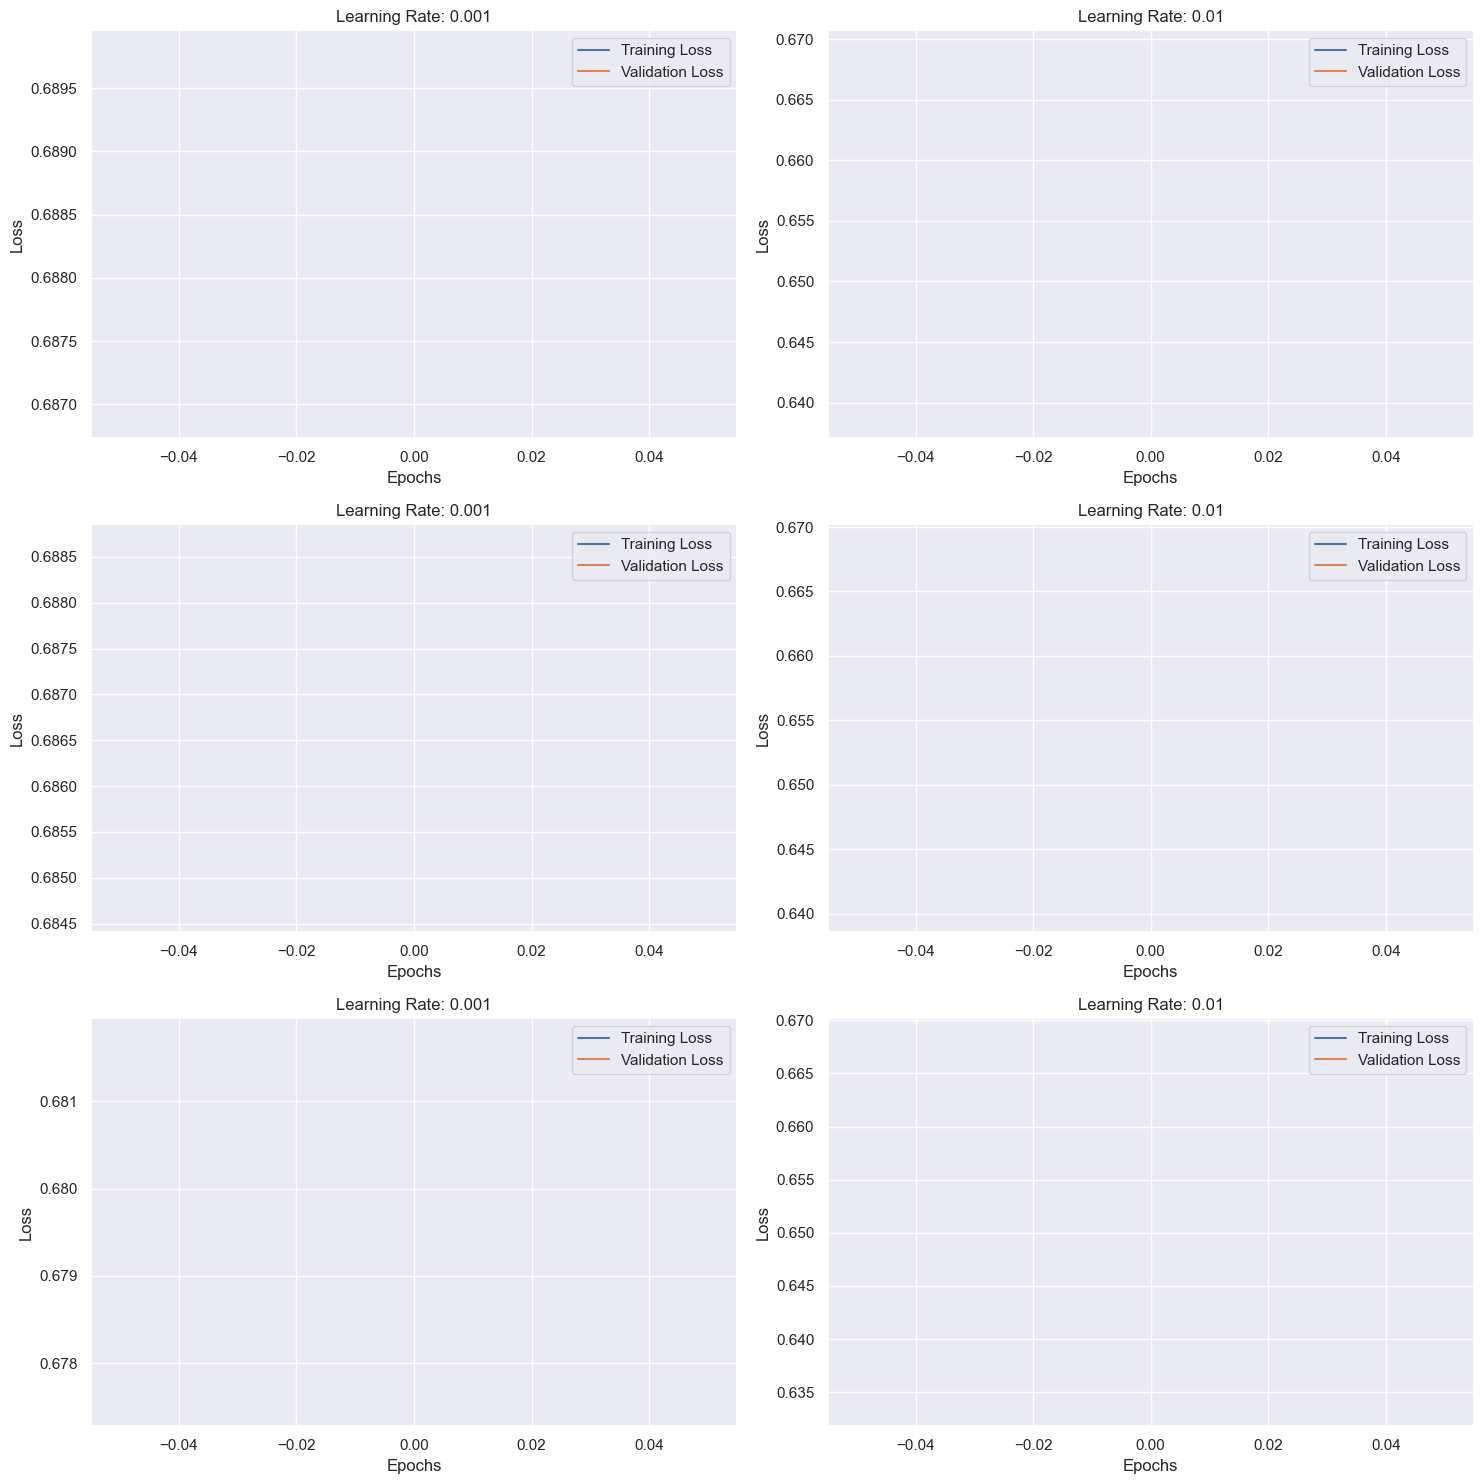

In [316]:
# Numero di subplot per riga
num_cols = 2

# Calcola il numero totale di subplot necessari
num_plots = len(results)

# Calcola il numero di righe necessarie
num_rows = (num_plots + num_cols - 1) // num_cols

# Crea una nuova figura
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten axs se num_rows è 1
if num_rows == 1:
    axs = [axs]

# Ciclo attraverso i risultati e plotta i grafici
for i, result in enumerate(results):
    # Estrai i dati di history
    history = result["metrics"]

    # Calcola la posizione del subplot corrente
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot training loss
    axs[row_idx][col_idx].plot(history.history['loss'], label='Training Loss')
    axs[row_idx][col_idx].plot(history.history['val_loss'], label='Validation Loss')
    axs[row_idx][col_idx].set_title(f'Learning Rate: {result["learning_rate"]}')
    axs[row_idx][col_idx].set_xlabel('Epochs')
    axs[row_idx][col_idx].set_ylabel('Loss')
    axs[row_idx][col_idx].legend()

# Mostra il grafico
plt.tight_layout()
plt.show()


In [290]:
def plot_loss(results):
     for i, result in enumerate(results):
        if i >= 3:
            break
        learning_rate = result["learning_rate"]
        history = result["metrics"]
        plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
        plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss for Learning Rate: {learning_rate}')
        plt.legend()
        plt.show()

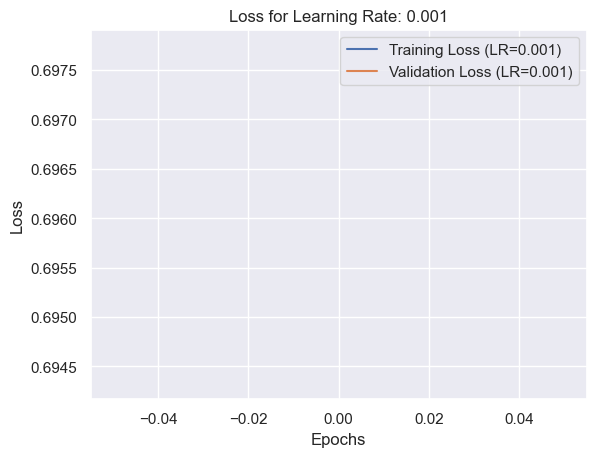

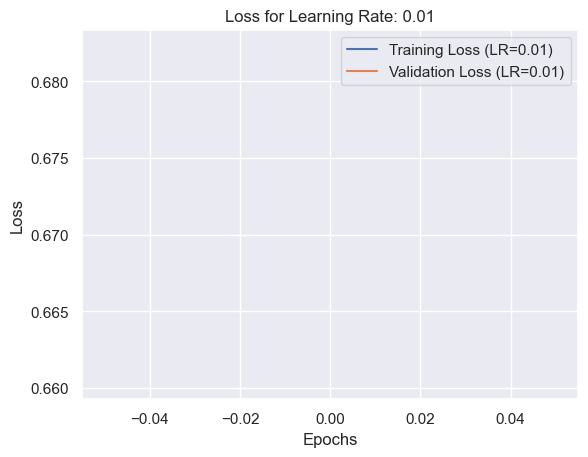

In [291]:
plot_loss(results)

In [317]:
# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)

 1/55 [..............................] - ETA: 4s

55/55 [==============================] - 0s 5ms/step
Report di classificazione:
                 precision    recall  f1-score   support

Defense Evasion       0.00      0.00      0.00         7
      Discovery       1.00      0.99      1.00      1752
      Execution       0.00      0.43      0.01         7
       Harmless       0.00      0.00      0.00        19
         Impact       0.00      0.00      0.00         2
          Other       0.00      0.00      0.00         0
    Persistence       1.00      0.90      0.95      1755

      micro avg       0.79      0.94      0.86      3542
      macro avg       0.29      0.33      0.28      3542
   weighted avg       0.99      0.94      0.96      3542
    samples avg       0.82      0.94      0.87      3542



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# VEC SIZE 200


In [318]:

#tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]

# Crea e addestra il modello Doc2Vec
vector_size = 200
doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Estrai le rappresentazioni vettoriali
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Definisci la funzione per creare il modello
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    
    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definisci i learning rate da testare
learning_rates = [0.001, 0.01, 0.1]

# Definisci il numero di epoche
epochs = 10





In [319]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)

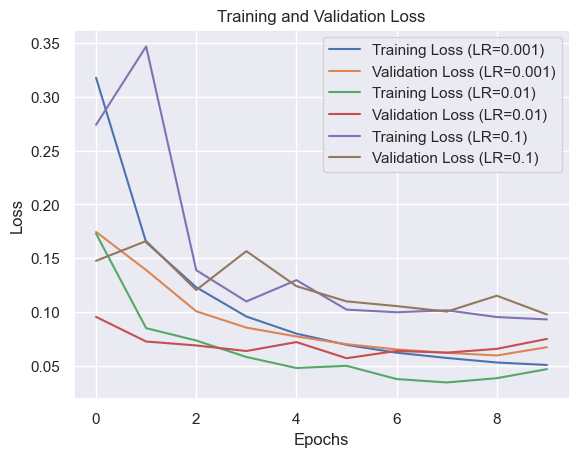

In [320]:
# Addestra e valuta il modello per ogni learning rate
for learning_rate in learning_rates:
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plotta le perdite di training e validation
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
# Mostra il grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

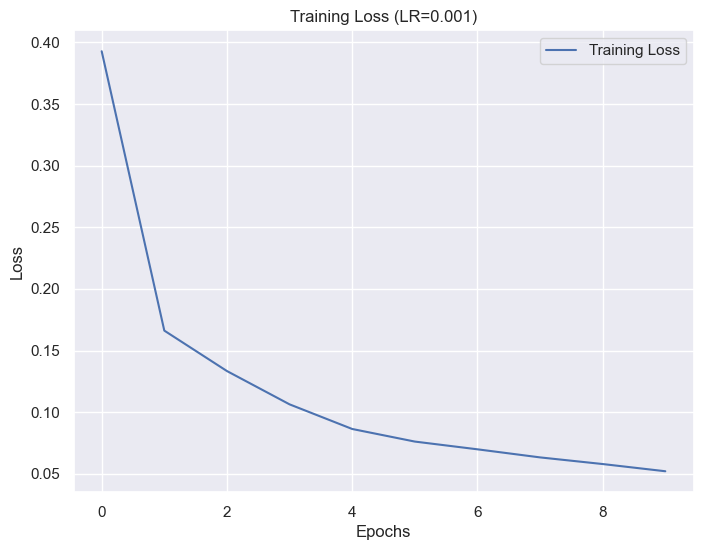

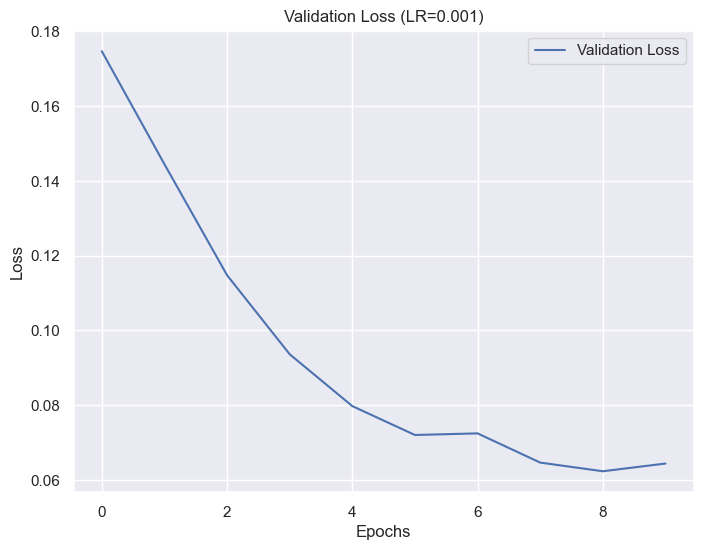

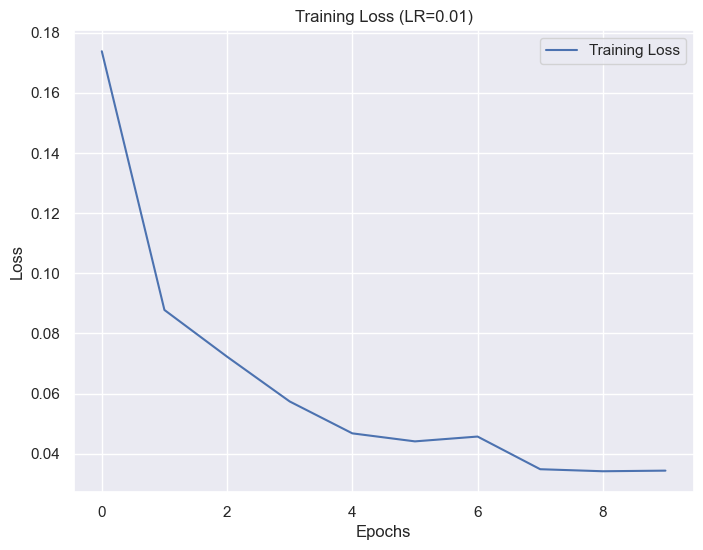

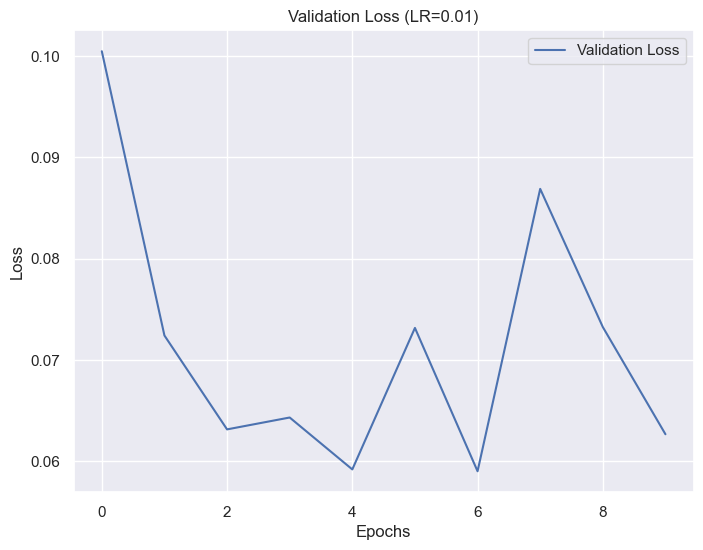

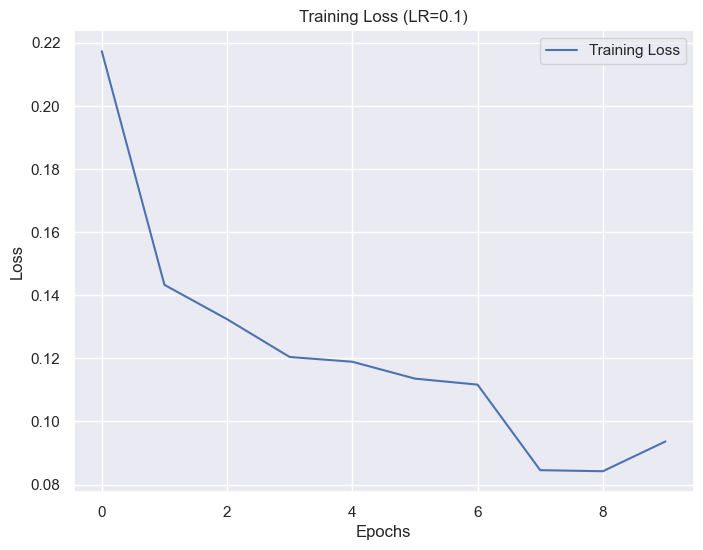

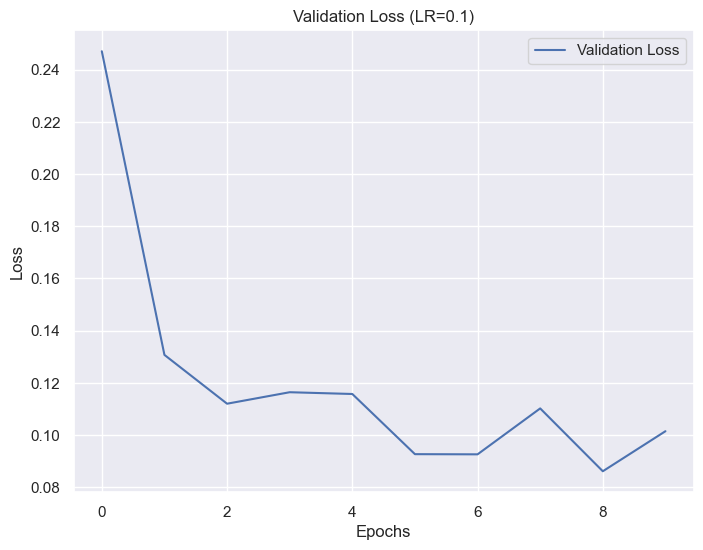

In [321]:
# Addestra e valuta il modello per ogni learning rate
sns.set_theme(style="darkgrid")
for learning_rate in learning_rates:
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plot per il training loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'Training Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot per il validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Validation Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

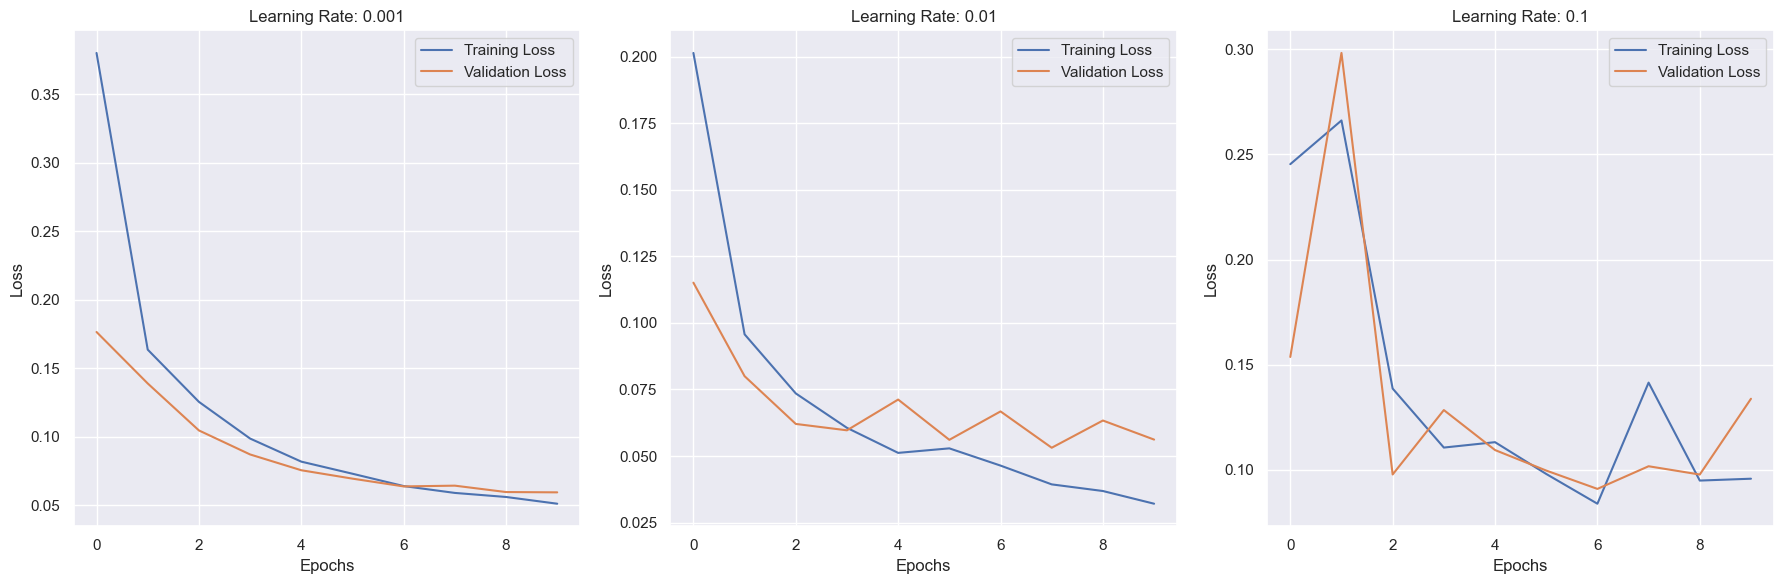

In [322]:
sns.set_theme(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, learning_rate in enumerate(learning_rates):
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plot per il training loss
    axs[i].plot(history.history['loss'], label='Training Loss')
    axs[i].plot(history.history['val_loss'], label='Validation Loss')
    axs[i].set_title(f'Learning Rate: {learning_rate}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [323]:
# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)

 26/129 [=====>........................] - ETA: 0s 

129/129 [==============================] - 0s 2ms/step
Report di classificazione:
                 precision    recall  f1-score   support

Defense Evasion       0.79      0.69      0.73       378
      Discovery       1.00      0.99      1.00      4098
      Execution       0.81      0.90      0.86      1463
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       0.97      0.97      0.97      3708

      micro avg       0.94      0.96      0.95      9647
      macro avg       0.51      0.51      0.51      9647
   weighted avg       0.95      0.96      0.96      9647
    samples avg       0.95      0.96      0.95      9647



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# different model, vecotr size, 200


 # VEC SIZE 800

In [300]:
vector_size = 800
doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Definisci la funzione per creare il modello
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    
    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definisci i learning rate da testare
learning_rates = [0.001, 0.01, 0.1]

# Definisci il numero di epoche
epochs = 10

mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)

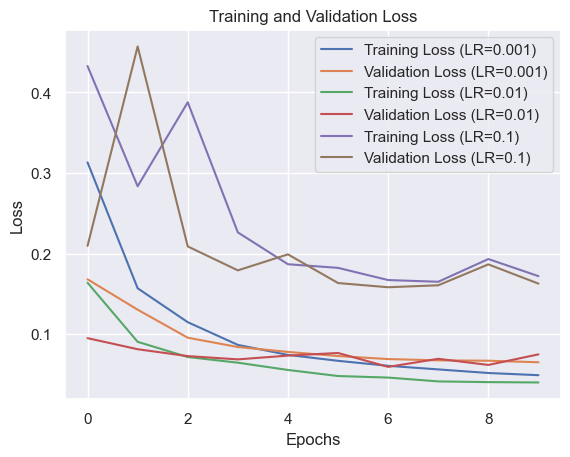

In [301]:
# Addestra e valuta il modello per ogni learning rate
for learning_rate in learning_rates:
    # Crea il modello
    model = create_model(vector_size, learning_rate)
    
    # Addestra il modello
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)
    
    # Plotta le perdite di training e validation
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
# Mostra il grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [302]:
# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)

129/129 [==============================] - 0s 2ms/step
Report di classificazione:
                 precision    recall  f1-score   support

Defense Evasion       0.66      0.65      0.65       331
      Discovery       1.00      0.99      1.00      4098
      Execution       0.00      0.00      0.00         0
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       0.98      0.96      0.97      3757

      micro avg       0.81      0.97      0.88      8186
      macro avg       0.38      0.37      0.37      8186
   weighted avg       0.97      0.97      0.97      8186
    samples avg       0.84      0.97      0.89      8186



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# END VEC SIZE 800

# TEST


## EXTRA

# FINE EXTRA

# FINE TEST

{'loss': [0.6891372203826904, 0.6810450553894043, 0.6731007695198059, 0.665261447429657, 0.65751713514328, 0.6498525738716125, 0.6422451734542847, 0.6346743702888489, 0.6271200180053711, 0.6195632815361023], 'auc': [0.769069254398346, 0.908869743347168, 0.9084604978561401, 0.9195902943611145, 0.912509024143219, 0.9115620255470276, 0.9228355884552002, 0.9140901565551758, 0.9172025918960571, 0.9208455085754395], 'precision': [0.9406337141990662, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581], 'recall': [0.7891627550125122, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592], 'val_loss': [0.6850049495697021, 0.6769940257072449, 0.6691017150878906, 0.6613118648529053, 0.6536135077476501, 0.6459805965423584, 0.6383958458900452, 0.6308

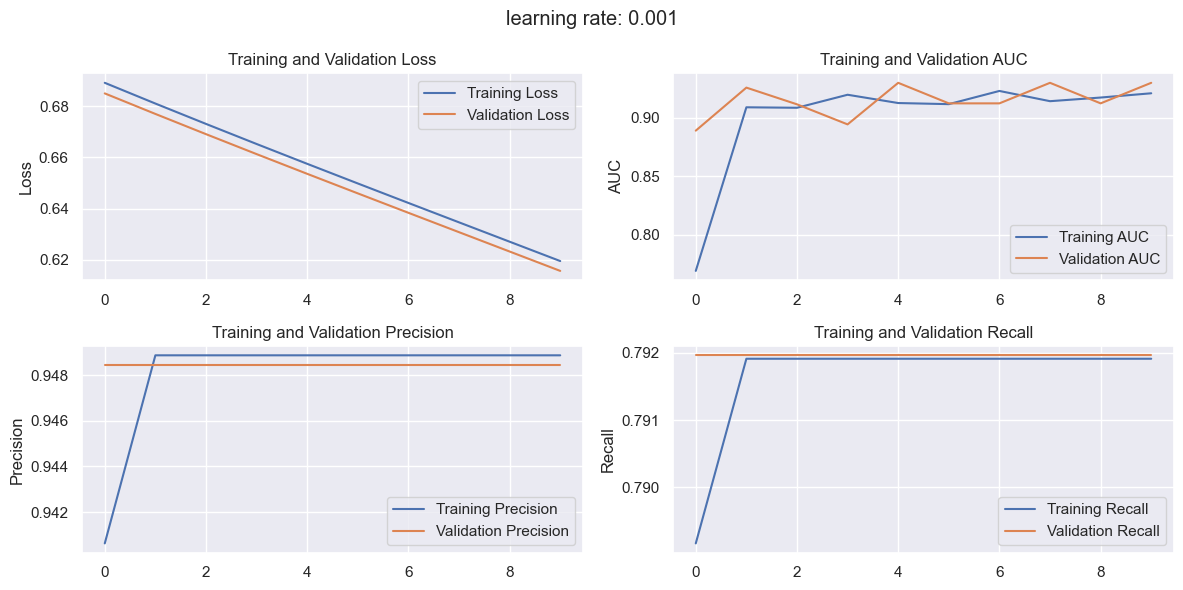

{'loss': [0.6515213847160339, 0.5664495825767517, 0.4632292687892914, 0.3351220190525055, 0.2448587566614151, 0.21784089505672455, 0.20978829264640808, 0.20616327226161957, 0.20419253408908844, 0.20312798023223877], 'auc': [0.9376811981201172, 0.9475717544555664, 0.9483457803726196, 0.9489297270774841, 0.9528278112411499, 0.9618797302246094, 0.9678966403007507, 0.9677150845527649, 0.9677738547325134, 0.9679584503173828], 'precision': [0.9204346537590027, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581], 'recall': [0.8024037480354309, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592], 'val_loss': [0.6094611883163452, 0.5189851522445679, 0.3999819755554199, 0.27607324719429016, 0.2261720448732376, 0.21291179955005646, 0.20800852775

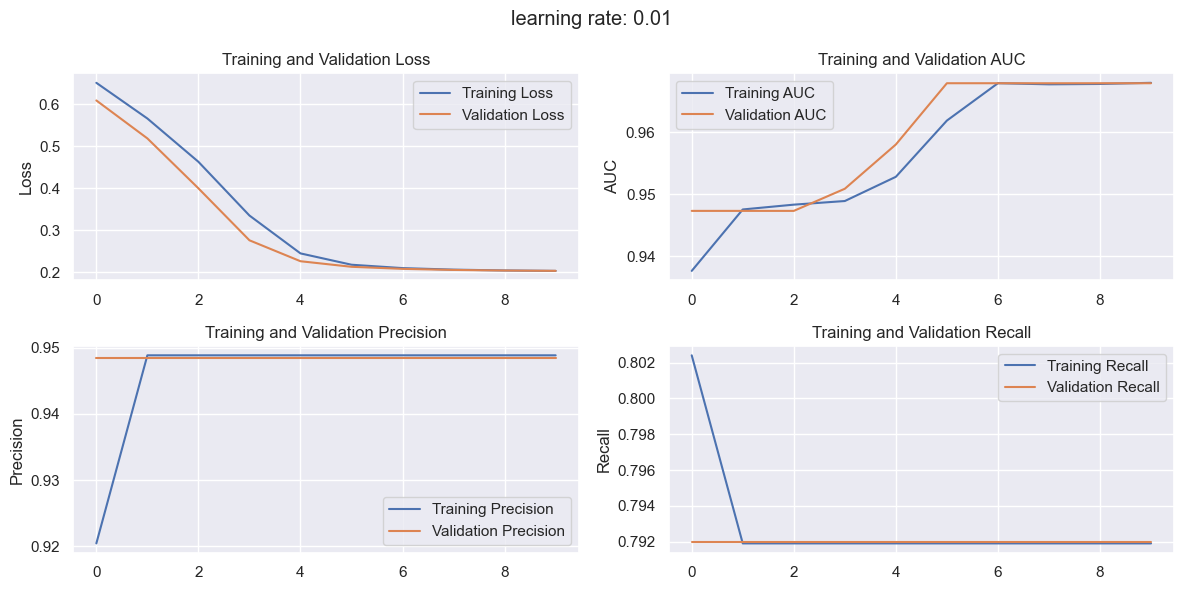

{'loss': [0.3736991882324219, 0.20349246263504028, 0.20189343392848969, 0.20203948020935059, 0.2027379274368286, 0.20208105444908142, 0.20200619101524353, 0.20200595259666443, 0.20208029448986053, 0.2018628865480423], 'auc': [0.9377899169921875, 0.9676713943481445, 0.9685541391372681, 0.9677766561508179, 0.9674429893493652, 0.9679378867149353, 0.9678680896759033, 0.9679491519927979, 0.9678514003753662, 0.9684574604034424], 'precision': [0.936229407787323, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9488649964332581, 0.9430639147758484, 0.9488649964332581, 0.9488649964332581], 'recall': [0.7880423665046692, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7919127941131592, 0.7962925434112549, 0.7919127941131592, 0.7919127941131592], 'val_loss': [0.20759940147399902, 0.20330405235290527, 0.20288057625293732, 0.21327447891235352, 0.2038479894399643, 0.20311808586120605, 0.2054305

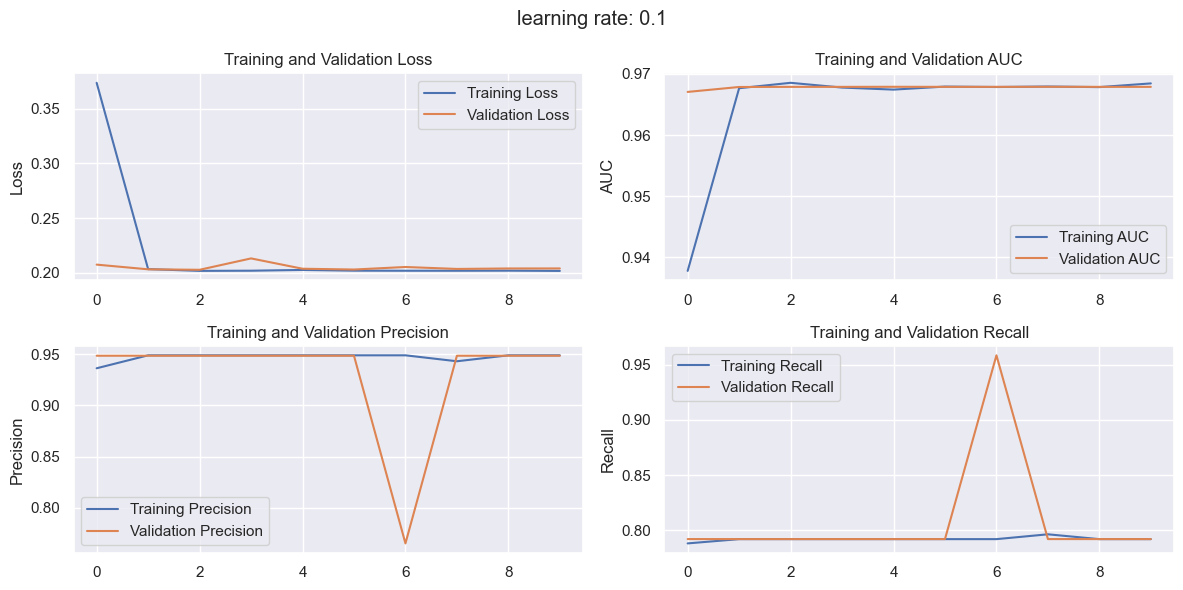

In [73]:
sns.set_theme(style="darkgrid")
for result in results:
    plt.figure(figsize=(12, 6))

    print(result.get("metrics").history)
    plt.suptitle(f"learning rate: {result.get('learning_rate')}")

    plt.subplot(2, 2, 1)
    plt.plot(result.get("metrics").history["loss"], label='Training Loss')
    plt.plot(result.get("metrics").history["val_loss"], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(result.get("metrics").history["auc"], label="Training AUC")
    plt.plot(result.get("metrics").history["val_auc"], label="Validation AUC")
    plt.title("Training and Validation AUC")
    plt.ylabel("AUC")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(result.get("metrics").history["precision"], label="Training Precision")
    plt.plot(result.get("metrics").history["val_precision"], label="Validation Precision")
    plt.title("Training and Validation Precision")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(result.get("metrics").history["recall"], label="Training Recall")
    plt.plot(result.get("metrics").history["val_recall"], label="Validation Recall")
    plt.title("Training and Validation Recall")
    plt.ylabel("Recall")
    plt.legend()


    plt.tight_layout()
    plt.show()

Results for Learning Rate: 0.1, Epochs: 5
Training Metrics:
The initial 5 epochs show significant improvements in various metrics. The loss decreases, and AUC, precision, and recall all exhibit positive trends. These improvements indicate that the model is learning from the data and adapting its parameters to better fit the training set.

Validation Metrics:
Validation metrics also show promising results after 5 epochs. The decreasing validation loss and improving AUC, precision, and recall suggest that the model generalizes well to unseen data.

Results for Learning Rate: 0.1, Epochs: 10
Training Metrics:
Extending training to 10 epochs results in continued improvements, albeit at a slower rate. The loss, AUC, precision, and recall all show positive trajectories, indicating ongoing refinement of the model.

Validation Metrics:
Validation metrics maintain consistency with training metrics, showcasing that the model's performance extends beyond the training set. The decreasing validation loss and improvements in AUC, precision, and recall suggest that the model is still benefiting from additional training.

Results for Learning Rate: 0.1, Epochs: 15
Training Metrics:
Training for 15 epochs demonstrates marginal improvements in metrics. The loss continues to decrease, but AUC, precision, and recall show slower rates of improvement, indicating potential diminishing returns.

Validation Metrics:
Validation metrics exhibit similar trends, with diminishing returns after 10 epochs. While the model continues to generalize, the rate of improvement decreases.

Discussion on Sufficient Epochs:
The observed trends suggest that the model achieves significant gains within the initial 5 to 10 epochs. Beyond this point, the rate of improvement diminishes, indicating that additional epochs may offer limited benefits. This phenomenon is often referred to as "early stopping," where training is halted once the model's performance plateaus, preventing overfitting.

Considering computational efficiency and avoiding overfitting, it seems reasonable to stop training around 10 epochs. This allows the model to capture the underlying patterns in the data without unnecessary computational costs.

6 Epochs: Stopping at 6 epochs appears to capture substantial improvements in the model. The trends indicate that the model is learning effectively, and additional epochs may provide diminishing returns.

10 Epochs: Extending training to 10 epochs could lead to further refinement, particularly in fine-tuning the model's parameters. However, this comes with increased computational cost.

Stopping at 6 epochs seems to strike a balance between efficiency and model performance

Comparison with Learning Rate: 0.1
Learning Rate: 0.01 vs. 0.1
Loss: The model with a learning rate of 0.01 generally achieves lower training and validation losses, indicating better convergence.
AUC: Both learning rates show similar positive trends in AUC, but 0.01 may provide slightly better discrimination ability.
Precision and Recall: Both learning rates lead to improved precision and recall, but 0.01 appears to offer slightly better performance.

The learning rate of 0.001 demonstrates effective learning, showing superior convergence and performance across key metrics compared to 0.01 and 0.1.
While both 0.01 and 0.1 show reasonable performance, 0.001 is a promising candidate for further experimentation and fine-tuning to optimize model performance.

In [258]:
def print_results_for_lr_and_epochs(learning_rate, epochs, results):
    print(f"\nResults for Learning Rate: {learning_rate}, Epochs: {epochs}\n")
    
    # Filter results for the specified learning rate and epochs
    lr_epochs_results = [result for result in results if result["learning_rate"] == learning_rate and result["epochs"] == epochs]

    for result in lr_epochs_results:
        # Print the metrics from history
        print("Training Metrics:")
        for metric_name, values in result["metrics"].history.items():
            print(f"{metric_name}: {values}")

        # Print validation metrics
        print("Validation Metrics:")
        for metric_name, values in result["metrics"].history.items():
            print(f"val_{metric_name}: {values}")

In [259]:
y_train_predictions = (model.predict(X_train_tensor) > 0.5).astype("int32")
y_test_predictions = (model.predict(X_test_tensor) > 0.5).astype("int32")

37/37 [==============================] - 0s 2ms/step


In [260]:
report_train = classification_report(y_train_mlb, y_train_predictions, target_names=mlb.classes_, output_dict=True)
df_report_train = pd.DataFrame(report_train).transpose()
df_report_train

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Defense Evasion,0.488889,0.170984,0.253359,386.0
Discovery,0.994660,1.000000,0.997323,4657.0
Execution,0.812803,0.800318,0.806512,1888.0
Harmless,0.000000,0.000000,0.000000,49.0
Impact,0.000000,0.000000,0.000000,10.0
Other,0.000000,0.000000,0.000000,14.0
Persistence,0.917292,0.982750,0.948893,4232.0
micro avg,0.927119,0.924973,0.926045,11236.0
macro avg,0.459092,0.422008,0.429441,11236.0
weighted avg,0.911124,0.924973,0.914982,11236.0


In [261]:
report_test = classification_report(y_test_mlb, y_test_predictions, target_names=mlb.classes_, output_dict=True)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Defense Evasion,0.441176,0.163043,0.238095,92.0
Discovery,0.988898,1.000000,0.994418,1158.0
Execution,0.786325,0.814159,0.800000,452.0
Harmless,0.000000,0.000000,0.000000,20.0
Impact,0.000000,0.000000,0.000000,4.0
Other,0.000000,0.000000,0.000000,3.0
Persistence,0.916152,0.980170,0.947080,1059.0
micro avg,0.919102,0.925036,0.922059,2788.0
macro avg,0.447507,0.422482,0.425656,2788.0
weighted avg,0.900773,0.925036,0.910330,2788.0


In [262]:
#loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(X_test_tensor, y_test_tensor)
loss_test, accuracy_test, precision_test, recall_test = model.evaluate(X_test_tensor, y_test_tensor)

 1/37 [..............................] - ETA: 1s - loss: 0.1582 - accuracy: 0.9062

37/37 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.9129


ValueError: not enough values to unpack (expected 4, got 2)

In [66]:
print_results_for_lr_and_epochs(0.001, 5, results)


Results for Learning Rate: 0.001, Epochs: 5



KeyError: 'epochs'

In [19]:
print_results_for_lr_and_epochs(0.001, 10, results)


Results for Learning Rate: 0.001, Epochs: 10



KeyError: 'epochs'

In [20]:
print_results_for_lr_and_epochs(0.001, 15, results)


Results for Learning Rate: 0.001, Epochs: 15



KeyError: 'epochs'

In [263]:
results[0].get("metrics").history

KeyError: 0